In [101]:
import numpy as np
import cv2, math, time
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

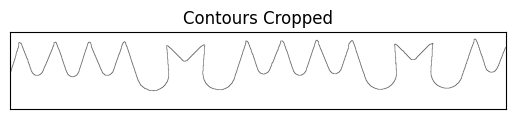

In [102]:
img = cv2.imread("Images\saw_01.png", 0)

ret,img_thresholded = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

kernel = np.ones((3,3),np.uint8)
img_contours = img_thresholded - cv2.erode(img_thresholded, kernel)     # Contours are white, background is black
img_contours_negative = 255 - img_contours                              # Contours are black, background is white

img_cc = img_contours_negative[400:600,:]
plt.imshow(img_cc, cmap = 'gray')
plt.title('Contours Cropped')
plt.xticks([]), plt.yticks([])
plt.show()
cv2.imwrite("Images\saw_01_contours_cropped.png", img_cc)
raw_contour = [[i,j] for i in range(img_cc.shape[0]) for j in range(img_cc.shape[1]) if img_cc[i,j] == 0]

In [103]:

## Gif of the contours being drawn, order of the points drawn is the order of the list raw_contours (from top to bottom)
#blank = np.ones((img_cc.shape[0], img_cc.shape[1]), np.uint8) * 255
#for i in raw_contours:
#    blank[i[0], i[1]] = 0
#    cv2.imshow('image', blank)
#    cv2.waitKey(1)
#
#cv2.waitKey(0)    
#cv2.destroyAllWindows()

In [104]:
def sort_contour_points(points):
    sorted_points = sorted(points, key=lambda p: p[1])
    start_point = sorted_points[0]
    sorted_points.remove(start_point)
    sorted_contour = [start_point]

    while sorted_points:
        last_point = sorted_contour[-1]

        euclidean_distances = [((last_point[0] - p[0]) ** 2 + (last_point[1] - p[1]) ** 2) ** 0.5 for p in sorted_points]
        min_distance = min(euclidean_distances)
        nearest_neighbors = [i for i in range(len(euclidean_distances)) if euclidean_distances[i] == min_distance]

        for i in sorted(nearest_neighbors, reverse=True):
            sorted_contour.append(sorted_points[i])
            sorted_points.remove(sorted_points[i])
            
    return sorted_contour

'''
Why has been necessary to sort the points of the contour?
    - The contour is a list of points that are not ordered in any way, so the first step is to order them in a way that
    makes sense. The order of the points is important because it will be used to calculate the angle between each pair of
    points, and the angle is the most important feature of the contour.
Why has been necessary to use the euclidean distance to sort the points?
    - The euclidean distance is used to find the nearest neighbor of a point, and it is used because it is the most
    straightforward way to find the nearest neighbor of a point in a 2D space.
Why has been necessary to use the nearest neighbors?
    - Because the nearest neighbors of a point are the next points in the contour, and it is important to find the nearest
    neighbors of a point to order the contour. 
'''

sorted_contour = sort_contour_points(raw_contour)

In [105]:
## Gif of the contours being drawn, order of the points drawn is the order of the list sorted_contour (from left to right)
#blank = np.ones((img_cc.shape[0], img_cc.shape[1]), np.uint8) * 255
#for i in sorted_contour:
#    blank[i[0], i[1]] = 0
#    cv2.imshow('image', blank)
#    cv2.waitKey(1)
#
#cv2.waitKey(0)    
#cv2.destroyAllWindows()

In [106]:
# Implementation of RDP Algorithm (Optimized)
def RDP_Algorithm(points, epsilon):
    # get the start and end points
    start = points[0]
    end = points[-1]

    # find distance from other points to line formed by start and end
    dist_point_to_line = DPTL(points, start, end)

    # get the index of the points with the largest distance
    max_value = max(dist_point_to_line)
    max_idx = dist_point_to_line.index(max_value) + 1 #since the first (and the last point) are not included in the calculation

    result = []
    if max_value > epsilon:
        if len(points[:max_idx+1]) == 2:
            result += [list(i) for i in points[:max_idx+1] if list(i) not in result]
        else:
            partial_results_left = RDP_Algorithm(points[:max_idx+1], epsilon)
            result += [list(i) for i in partial_results_left if list(i) not in result]
        if len(points[max_idx:]) == 2:
            result += [list(i) for i in points[max_idx:] if list(i) not in result]
        else:
            partial_results_right = RDP_Algorithm(points[max_idx:], epsilon)
            result += [list(i) for i in partial_results_right if list(i) not in result]
    else:
        result += [points[0], points[-1]]
    
    return result

def DPTL(points, start, end):
    # return a list of distances: distance of each point in points to line formed by start and end

    # compute the angular coefficient and the constant of the line formed by start and end
    # y - mx - q = 0
    a = start[1] - end[1]
    b = end[0] - start[0]
    c = - a*start[0] - b*start[1] 

    return [abs(a*points[i][0]+b*points[i][1]+c)/(math.sqrt(a**2+b**2)) for i in range(1,len(points)-1)]

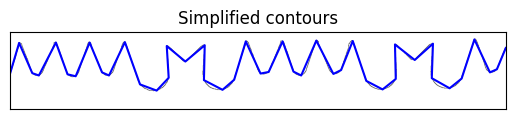

In [107]:
simplified_contours = RDP_Algorithm(sorted_contour, epsilon = 10)
simplified_contours = np.array(simplified_contours)
plt.plot(simplified_contours[:,1], simplified_contours[:,0], 'b')
plt.imshow(img_cc, cmap = 'gray')
plt.title('Simplified contours')
plt.xticks([]), plt.yticks([])
plt.show()

In [108]:
# TO TEST
def curvature(points):
    """
    Calculate the curvature of a curve represented by a list of points using finite differences.
    
    Args:
    - points: List of tuples representing the points [(x1, y1), (x2, y2), ...]
    
    Returns:
    - List of curvature values corresponding to each point in the curve
    """
    curvature_values = []
    
    for i in range(len(points)):
        # Three consecutive points
        p1 = points[max(0, i - 1)]
        p2 = points[i]
        p3 = points[min(len(points) - 1, i + 1)]
        
        # Vectors between consecutive points
        v1 = np.array(p2) - np.array(p1)
        v2 = np.array(p3) - np.array(p2)
        
        # Cross product magnitude (twice the area of the triangle)
        cross_product_magnitude = np.cross(v1, v2)
        
        # Distance between consecutive points
        distance_p1_p2 = np.linalg.norm(v1)
        distance_p2_p3 = np.linalg.norm(v2)
        
        # If distance is zero, curvature is undefined
        if distance_p1_p2 == 0 or distance_p2_p3 == 0:
            curvature_values.append(0)  # Set curvature to zero
        else:
            # Curvature is twice the area divided by the product of distances squared
            curvature = 2 * cross_product_magnitude / (distance_p1_p2 * distance_p2_p3 * (distance_p1_p2 + distance_p2_p3))
            curvature_values.append(curvature)
    
    return curvature_values



def fit_circle_arc(points):
    """
    Fit a circular arc to a set of points using curve fitting.
    
    Args:
    - points: List of tuples representing the points [(x1, y1), (x2, y2), ...]
    
    Returns:
    - Tuple (x_center, y_center, radius) representing the center and radius of the fitted circle
    """
    # Define the function for a circle (x - x_center)^2 + (y - y_center)^2 = radius^2
    def circle_func(x, x_center, y_center, radius):
        return (radius**2 - (x - x_center)**2)**0.5 + y_center
    
    # Initial guess for circle parameters (center and radius)
    x_center_guess = np.mean([p[0] for p in points])
    y_center_guess = np.mean([p[1] for p in points])
    radius_guess = np.mean([np.linalg.norm(np.array(p) - np.array((x_center_guess, y_center_guess))) for p in points])
    initial_guess = (x_center_guess, y_center_guess, radius_guess)
    
    # Fit the circle parameters to the points using curve fitting
    popt, _ = curve_fit(circle_func, [p[0] for p in points], [p[1] for p in points], p0=initial_guess)
    
    return popt[0], popt[1], popt[2]



def isolate_circular_arcs(points, curvature_threshold):
    """
    Isolate circular arcs from an open contour represented by a list of points.
    
    Args:
    - points: List of tuples representing the points [(x1, y1), (x2, y2), ...]
    - curvature_threshold: Threshold value for curvature indicating the presence of a circular arc
    
    Returns:
    - List of tuples (start_index, end_index) representing the indices of points belonging to each circular arc
    """
    # Calculate curvature
    curvature_values = curvature(points)
    
    # Identify regions with curvature above the threshold
    arc_indices = []
    current_arc_start = None
    
    for i, c in enumerate(curvature_values):
        if c > curvature_threshold:
            if current_arc_start is None:
                current_arc_start = i
        else:
            if current_arc_start is not None:
                arc_indices.append((current_arc_start, i-1))
                current_arc_start = None
    
    if current_arc_start is not None:
        arc_indices.append((current_arc_start, len(points)-1))
    
    return arc_indices